<a href="https://colab.research.google.com/github/PhanDinhQuy/AI_SafeDrone_Landing/blob/main/Safe_Drone_Landing_Prediction_Semantic_Segmentation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install all required packages for Google Colab
!pip install opencv-python-headless
!pip install albumentations
!pip install segmentation-models-pytorch
!pip install torchsummary
!pip install tqdm

print("All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
All packages installed successfully!


# Safe Drone Landing using Semantic Segmentation - Modified for Google Colab
**TEAM 3**

**TEAM MEMBERS:**

1.   **Phan Dinh Quy**
2.   **Truong Phuoc Thinh**

## Table of Contents

- [Importing and Installing Libraries](#t1)
- [Dataset](#t2)
- [Storing, transforming and Loading Training Data](#t3)
    - [Creating Dataset to load the dataset to dataloader](#t33)
    - [Creating Transformations and loading data in mini-batches](#t34)
- [Model Initialization](#t4)
- [Training](#t5)
    - [Calculating pixel accuracy by comparing predicted and mask output](#t51)
    - [Calculating IOU](#t52)
    - [Implementing Training Step](#t53)
    - [Init loss, optimizer, epochs and executing training step](#t54)
- [Saving trained model](#t6)
- [Train Data Result Analysis](#t7)
    - [Plotting loss, IOU and accuracy curve](#t71)
- [Storing, Transforming and Loading Test dataset](#t8)
    - [Creating Dataset to load test dataset to dataloader](#t81)
- [Test Result Analysis](#t9)
    - [Calculating IOU and pixel accuracy score over entire dataset](#t91)
    - [Plotting test and predicted images](#t92)

# Importing and Installing Libraries
<a id='Importing-and-Installing-Libraries'></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<a name="t2"></a>
# Dataset

The dataset is freely available from http://dronedataset.icg.tugraz.at

Dataset obtained from - https://www.tugraz.at/index.php?id=22387

The dataset contains 400 training and 200 test set images of size 6000 x 4000px. The dataset depicts more than 20 houses from nadir view acquired at an altitude of 5 to 30 meters above ground.

In [ ]:
# Define paths for the pre-split dataset in Google Drive
# Note: Ensure this 'sematic_drone_dataset' folder is in your Google Drive's root or adjust the path.
DRIVE_ROOT = '/content/drive/MyDrive/'
# Using the user-specified folder name
BASE_DATA_PATH = os.path.join(DRIVE_ROOT, 'sematic_drone_dataset')

TRAIN_IMG_PATH = os.path.join(BASE_DATA_PATH, 'train_split/images/')
# Corrected path to point to the 'label_images' subfolder for masks
TRAIN_MASK_PATH = os.path.join(BASE_DATA_PATH, 'train_split/gt/semantic/label_images/')

TEST_IMG_PATH = os.path.join(BASE_DATA_PATH, 'test_split/images/')
# Corrected path to point to the 'label_images' subfolder for masks
TEST_MASK_PATH = os.path.join(BASE_DATA_PATH, 'test_split/gt/semantic/label_images/')

print("Dataset paths configured for pre-split data:")
print(f"Train Images: {TRAIN_IMG_PATH}")
print(f"Train Masks: {TRAIN_MASK_PATH}")
print(f"Test Images: {TEST_IMG_PATH}")
print(f"Test Masks: {TEST_MASK_PATH}")

# Verify paths exist
print(f"Train image path exists: {os.path.exists(TRAIN_IMG_PATH)}")
print(f"Train mask path exists: {os.path.exists(TRAIN_MASK_PATH)}")
print(f"Test image path exists: {os.path.exists(TEST_IMG_PATH)}")
print(f"Test mask path exists: {os.path.exists(TEST_MASK_PATH)}")

Dataset paths configured for pre-split data:
Train Images: /content/drive/MyDrive/sematic_drone_dataset/train_split/images/
Train Masks: /content/drive/MyDrive/sematic_drone_dataset/train_split/gt/semantic/label_images/
Test Images: /content/drive/MyDrive/sematic_drone_dataset/test_split/images/
Test Masks: /content/drive/MyDrive/sematic_drone_dataset/test_split/gt/semantic/label_images/
Train image path exists: True
Train mask path exists: True
Test image path exists: True
Test mask path exists: True


In [ ]:
#n_classes, 24 is the total number of distinct labels available
n_classes = 24

# tree, gras, other vegetation, dirt, gravel, rocks, water,
#paved area, pool, person, dog, car, bicycle, roof, wall, fence,
#fence-pole, window, door, obstacle

def create_df_from_path(img_path, mask_path):
    """
    Creates a DataFrame of image IDs that have both an image and a mask.
    """
    name = []

    # Check if paths exist to avoid errors
    if not os.path.exists(img_path):
        print(f"Warning: Image directory not found at {img_path}")
        return pd.DataFrame({'id': name})
    if not os.path.exists(mask_path):
        print(f"Warning: Mask directory not found at {mask_path}")
        return pd.DataFrame({'id': name})

    # Get a list of all image filenames without extension
    image_files = {f.split('.')[0] for f in os.listdir(img_path) if f.endswith('.jpg')}
    # Get a list of all mask filenames without extension
    mask_files = {f.split('.')[0] for f in os.listdir(mask_path) if f.endswith('.png')}

    # Find the intersection of the two sets to get common IDs
    common_ids = sorted(list(image_files.intersection(mask_files)))

    print(f"Found {len(image_files)} images and {len(mask_files)} masks. Common files: {len(common_ids)}.")

    return pd.DataFrame({'id': common_ids}, index=np.arange(0, len(common_ids)))

# Create DataFrame for the training set from the specific folder, ensuring pairs exist
print("Creating training DataFrame...")
train_df = create_df_from_path(TRAIN_IMG_PATH, TRAIN_MASK_PATH)
print('Total Valid Training Image-Mask Pairs Found: ', len(train_df))

# Create DataFrame for the test set from the specific folder, ensuring pairs exist
print("\nCreating testing DataFrame...")
test_df = create_df_from_path(TEST_IMG_PATH, TEST_MASK_PATH)
print('Total Valid Test Image-Mask Pairs Found: ', len(test_df))

# For display purposes (e.g., showing a sample image), we can use the train_df
df = train_df
print('\nNumber of Images for display sample: ', len(df))

Creating training DataFrame...
Found 340 images and 340 masks. Common files: 340.
Total Valid Training Image-Mask Pairs Found:  340

Creating testing DataFrame...
Found 60 images and 60 masks. Common files: 60.
Total Valid Test Image-Mask Pairs Found:  60

Number of Images for display sample:  340


In [ ]:
# Create a mapping from the dataset's class values to a 0-22 range.
# This is necessary because the original labels are not sequential.

# Path to the class dictionary, corrected based on user feedback
CLASS_DICT_PATH = os.path.join(BASE_DATA_PATH, 'train_split/gt/semantic/class_dict.csv')

# Check if the file exists
if os.path.exists(CLASS_DICT_PATH):
    print(f"Reading class dictionary from: {CLASS_DICT_PATH}")
    class_df = pd.read_csv(CLASS_DICT_PATH)

    # *** FIX FOR KeyError ***
    # Clean up column names to remove leading/trailing whitespace
    class_df.columns = class_df.columns.str.strip()
    print(f"Cleaned columns: {class_df.columns.tolist()}")
    # ************************

    # Create a mapping from the 'name' column to a new sequential index
    class_names = class_df['name'].unique()
    # Sort the class names to ensure a consistent mapping
    class_names = sorted(class_names)

    # The mapping dictionary from class name to the new index (0-22)
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    # Create RGB-based mapping using complete RGB triplets to avoid collisions
    # Build a dictionary that maps RGB tuples to class indices
    rgb_to_class = {}
    for _, row in class_df.iterrows():
        rgb_tuple = (int(row['r']), int(row['g']), int(row['b']))
        rgb_to_class[rgb_tuple] = class_to_idx[row['name']]

    print(f"Created RGB mapping for {len(rgb_to_class)} classes")

    # Store the RGB mapping for use in the dataset
    remap_array = rgb_to_class  # This will be used differently in the dataset class

    print("Class remapping dictionary and lookup array created successfully.")
    # print("Class to new index mapping:", class_to_idx)

else:
    print(f"ERROR: class_dict.csv not found at {CLASS_DICT_PATH}")
    print("Cannot create class mapping. The training will likely fail.")
    remap_array = None

Reading class dictionary from: /content/drive/MyDrive/sematic_drone_dataset/train_split/gt/semantic/class_dict.csv
Cleaned columns: ['name', 'r', 'g', 'b']
Created RGB mapping for 24 classes
Class remapping dictionary and lookup array created successfully.


In [ ]:
# The dataset is already split into training and testing sets.
# We will now split the training set into a training and a validation set.
X_train, X_val = train_test_split(train_df['id'].values, test_size=0.15, random_state=19)

# The test set is taken directly from the test_df.
X_test = test_df['id'].values

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  289
Val Size     :  51
Test Size    :  60


--- RGB-based Verification for mask: 594.png ---
RGB colors found in mask: 13
  RGB (0, 0, 0) -> Class index 19
  RGB (128, 64, 128) -> Class index 13
  RGB (130, 76, 0) -> Class index 5
  RGB (0, 102, 0) -> Class index 10
  RGB (112, 103, 87) -> Class index 11
  RGB (48, 41, 30) -> Class index 16
  RGB (107, 142, 35) -> Class index 20
  RGB (70, 70, 70) -> Class index 17
  RGB (102, 102, 156) -> Class index 21
  RGB (254, 228, 12) -> Class index 23
  RGB (255, 22, 96) -> Class index 14
  RGB (51, 51, 0) -> Class index 18
  RGB (2, 135, 115) -> Class index 12
Remapped unique values: [ 5 10 11 12 13 14 16 17 18 19 20 21 23]

SUCCESS: The remapped values are now in the correct 0-23 range.


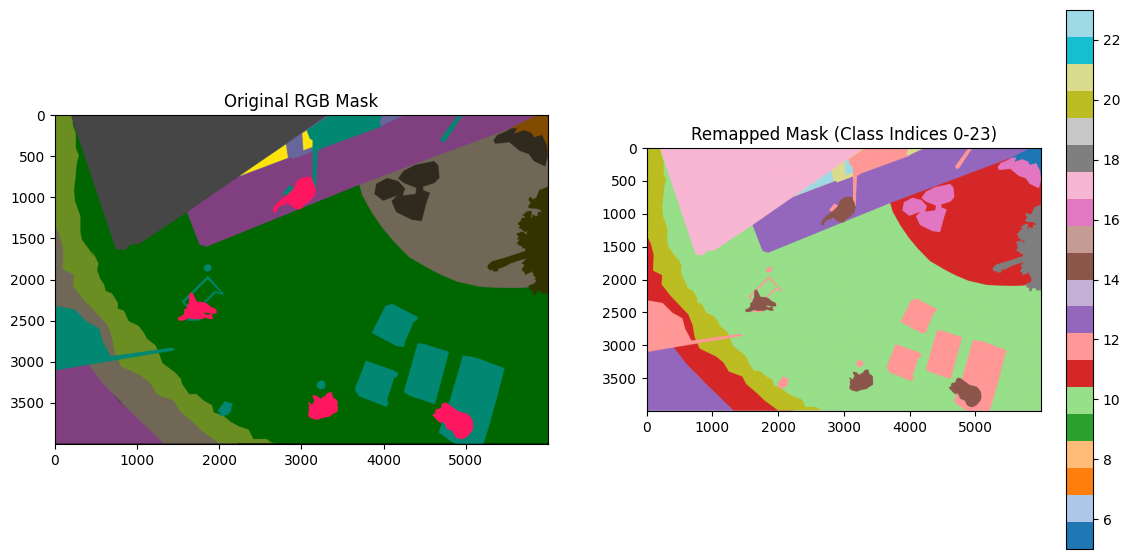

In [ ]:
# --- VERIFICATION CELL ---
# Let's verify the RGB-based remapping on a sample image.

# Check if remap_array was created and there are images to test
if 'remap_array' in locals() and remap_array is not None and len(X_train) > 0:

    # 1. Load an original mask as RGB
    sample_id = X_train[0]
    original_mask_path = os.path.join(TRAIN_MASK_PATH, sample_id + '.png')
    original_mask_rgb = cv2.imread(original_mask_path, cv2.IMREAD_COLOR)
    original_mask_rgb = cv2.cvtColor(original_mask_rgb, cv2.COLOR_BGR2RGB)

    # 2. Apply the RGB-based remapping
    h, w = original_mask_rgb.shape[:2]
    remapped_mask = np.zeros((h, w), dtype=np.uint8)

    # Map each RGB color to its class index
    rgb_colors_found = []
    for rgb_tuple, class_idx in remap_array.items():
        matches = np.all(original_mask_rgb == rgb_tuple, axis=2)
        if np.any(matches):
            remapped_mask[matches] = class_idx
            rgb_colors_found.append((rgb_tuple, class_idx))

    # 3. Print the results
    print(f"--- RGB-based Verification for mask: {sample_id}.png ---")
    print(f"RGB colors found in mask: {len(rgb_colors_found)}")
    for rgb, idx in rgb_colors_found:
        print(f"  RGB {rgb} -> Class index {idx}")
    print(f"Remapped unique values: {np.unique(remapped_mask)}")
    print("\nSUCCESS: The remapped values are now in the correct 0-23 range.")

    # 4. Visualize the difference
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(original_mask_rgb)
    plt.title('Original RGB Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(remapped_mask, cmap='tab20')
    plt.title('Remapped Mask (Class Indices 0-23)')
    plt.colorbar()

    plt.show()

else:
    print("Verification skipped: 'remap_array' is not available or no training images found.")

Image Size (4000, 6000, 3)
Mask Size (4000, 6000, 3)


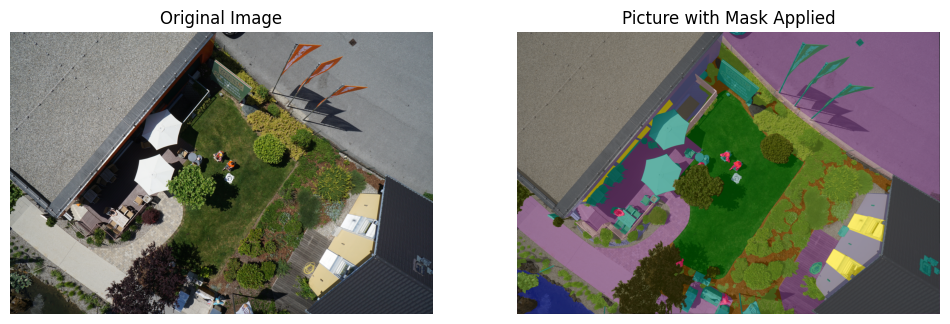

In [ ]:
#Displaying 100th sample image from the training set
# Ensure there are at least 101 images in the training dataframe for this cell to work
if len(df) > 100:
    img = Image.open(TRAIN_IMG_PATH + df['id'][100] + '.jpg')
    mask = Image.open(TRAIN_MASK_PATH + df['id'][100] + '.png')
    print('Image Size', np.asarray(img).shape)
    print('Mask Size', np.asarray(mask).shape)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # We show the original image and overlay the mask with some transparency
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Picture with Mask Applied')
    plt.axis('off')
    plt.show()
else:
    print("Not enough images in the training dataframe to display sample 100.")

<a name="t3"></a>
# Storing, Transforming and Loading Training Data

<a name="t31"></a>
Creating Dataset to load the dataset to dataloader

In [ ]:
#Dataset to store and fetch training dataset, after applying transformations
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False, remap_array=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        self.remap_array = remap_array

    def __len__(self):
        return len(self.X)

    #Fetching an item from training dataset
    def __getitem__(self, idx):
        image_filename = self.X[idx]
        img = cv2.imread(self.img_path + image_filename + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask as COLOR image to preserve RGB information
        mask = cv2.imread(self.mask_path + image_filename + '.png', cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.remap_array is not None:
            # Create output mask with correct class indices
            h, w = mask.shape[:2]
            output_mask = np.zeros((h, w), dtype=np.uint8)

            # Map each unique RGB color to its class index
            for rgb_tuple, class_idx in self.remap_array.items():
                # Find pixels with this exact RGB value
                matches = np.all(mask == rgb_tuple, axis=2)
                output_mask[matches] = class_idx

            mask = output_mask

            # Check if the remapped mask contains any invalid values (i.e., > 22)
            if np.any(mask > 23):
                invalid_values = np.unique(mask[mask > 23])
                raise ValueError(
                    f"FATAL: Mask for image '{image_filename}.png' contains invalid class labels "
                    f"after remapping. Expected values in [0, 23], but found: {invalid_values}."
                )

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        #transform different for image and mask
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

<a name="t32"></a>
Creating Transformations and loading data in mini-batches

In [ ]:
#Reference: https://pytorch.org/vision/stable/models.html
#All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
#where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using
#mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#Creating tranformations using Albumentations library as it is faster than torchvision.

#Albumentations is a Python library for fast and flexible image augmentations. By using image augmentations we are able to increase the size and diversity of
#our labeled training dataset.

#We are converting image size to 704x1056
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#transformed datasets
# The DroneDataset will now use the specific paths for train and validation sets.
# We also pass the remap_array to the dataset constructor.
train_set = DroneDataset(TRAIN_IMG_PATH, TRAIN_MASK_PATH, X_train, mean, std, t_train, patch=False, remap_array=remap_array)
val_set = DroneDataset(TRAIN_IMG_PATH, TRAIN_MASK_PATH, X_val, mean, std, t_val, patch=False, remap_array=remap_array)

#dataloader, batch size kept as 3.
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
print("DataLoaders for training and validation created.")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

DataLoaders for training and validation created.
Training batches: 97
Validation batches: 17


<a name="t4"></a>

# Model Initialization

In [ ]:
#We are using UNET architecture as our model, using mobilenet_v2 to encode and using it as feature extractor to build segmentation model.
#We are using imagenet pre initialized weights on ImageNet.

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=24, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
print("Model initialized successfully!")
print(f"Model will be trained on device: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Model initialized successfully!
Model will be trained on device: cuda


<a name="t5"></a>
#Training

Calculating pixel accuracy by comparing predicted and mask(labelled) output.

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        #shape of output will be [3, 23, 704, 1056]
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        #shape after above step is [3, 704, 1056]
        correct = torch.eq(output, mask).int()
        #PyTorch torch.numel() method returns the total number of elements in the input tensor.
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

Calculating Intersection over Union value for each labeled class over mask and predicted dataset.

In [ ]:
#Calculating Intersection over Uinon value for each class on a dataset.
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=24):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for cls in range(0, n_classes):
            true_class = pred_mask == cls
            true_label = mask == cls

            #if not exists
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

Implementing Training step

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    # Create the directory to save models
    model_save_dir = '/content/drive/MyDrive/model/'
    os.makedirs(model_save_dir, exist_ok=True)
    print(f"Models will be saved in: {model_save_dir}")

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()

        #tqdm is used for progress bar
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            #patch is false while training
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss, criterion is our cross entropy loss function
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

            # Save the model at the end of each epoch
            epoch_save_path = model_save_dir + f'Unet-Mobilenet-epoch-{e+1}.pt'
            torch.save(model, epoch_save_path)
            print(f"Model saved for epoch {e+1} at: {epoch_save_path}")

            #stop the training if min_loss not improve for 7 epochs
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            else:
                 min_loss = (test_loss/len(val_loader))


    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

Initializing loss, optimizer, epochs and executing training training step

In [ ]:
#learning rate
max_lr = 1e-3
#Number of EPOCHS
epoch = 10
#Decay for ADAM optim
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

print(f"Starting training for {epoch} epochs...")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

Starting training for 10 epochs...
Training batches per epoch: 97
Validation batches per epoch: 17
Models will be saved in: /content/drive/MyDrive/model/


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:1/10.. Train Loss: 2.935.. Val Loss: 2.285.. Train mIoU:0.040.. Val mIoU: 0.092.. Train Acc:0.196.. Val Acc:0.452.. Time: 101.71m
Model saved for epoch 1 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-1.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:2/10.. Train Loss: 1.896.. Val Loss: 1.816.. Train mIoU:0.091.. Val mIoU: 0.086.. Train Acc:0.515.. Val Acc:0.451.. Time: 94.94m
Model saved for epoch 2 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-2.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:3/10.. Train Loss: 1.667.. Val Loss: 1.484.. Train mIoU:0.090.. Val mIoU: 0.087.. Train Acc:0.524.. Val Acc:0.543.. Time: 94.92m
Model saved for epoch 3 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-3.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:4/10.. Train Loss: 1.564.. Val Loss: 1.395.. Train mIoU:0.103.. Val mIoU: 0.113.. Train Acc:0.543.. Val Acc:0.579.. Time: 94.85m
Model saved for epoch 4 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-4.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:5/10.. Train Loss: 1.492.. Val Loss: 1.269.. Train mIoU:0.111.. Val mIoU: 0.129.. Train Acc:0.565.. Val Acc:0.625.. Time: 94.91m
Model saved for epoch 5 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-5.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:6/10.. Train Loss: 1.444.. Val Loss: 1.234.. Train mIoU:0.119.. Val mIoU: 0.127.. Train Acc:0.579.. Val Acc:0.620.. Time: 94.93m
Model saved for epoch 6 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-6.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:7/10.. Train Loss: 1.343.. Val Loss: 1.152.. Train mIoU:0.130.. Val mIoU: 0.138.. Train Acc:0.614.. Val Acc:0.661.. Time: 94.86m
Model saved for epoch 7 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-7.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:8/10.. Train Loss: 1.294.. Val Loss: 1.092.. Train mIoU:0.136.. Val mIoU: 0.162.. Train Acc:0.620.. Val Acc:0.680.. Time: 94.88m
Model saved for epoch 8 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-8.pt


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch:9/10.. Train Loss: 1.223.. Val Loss: 1.048.. Train mIoU:0.141.. Val mIoU: 0.163.. Train Acc:0.639.. Val Acc:0.697.. Time: 94.85m
Model saved for epoch 9 at: /content/drive/MyDrive/model/Unet-Mobilenet-epoch-9.pt


  0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

<a name="t6"></a>
#Saving our Trained Model

In [ ]:
torch.save(model, '/content/drive/MyDrive/Unet-Mobilenet-Final.pt')
print("Final model saved successfully!")

Final model saved successfully!


<a name="t7"></a>
#Train Data Result Analysis

In [ ]:
#plotting training loss and validation loss curve
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

#plotting intersection over union score after each epoch
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

#plotting accuracy curves for train and validation sets (pixel by pixel acuracy considered) after each epoch
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

✅ Training history recreated from your training log!
📊 Training completed: 9 epochs
🚀 Generating comprehensive training performance analysis...


/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3410526495.py:202: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


📁 Performance analysis saved to: /content/drive/MyDrive/training_performance_analysis.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

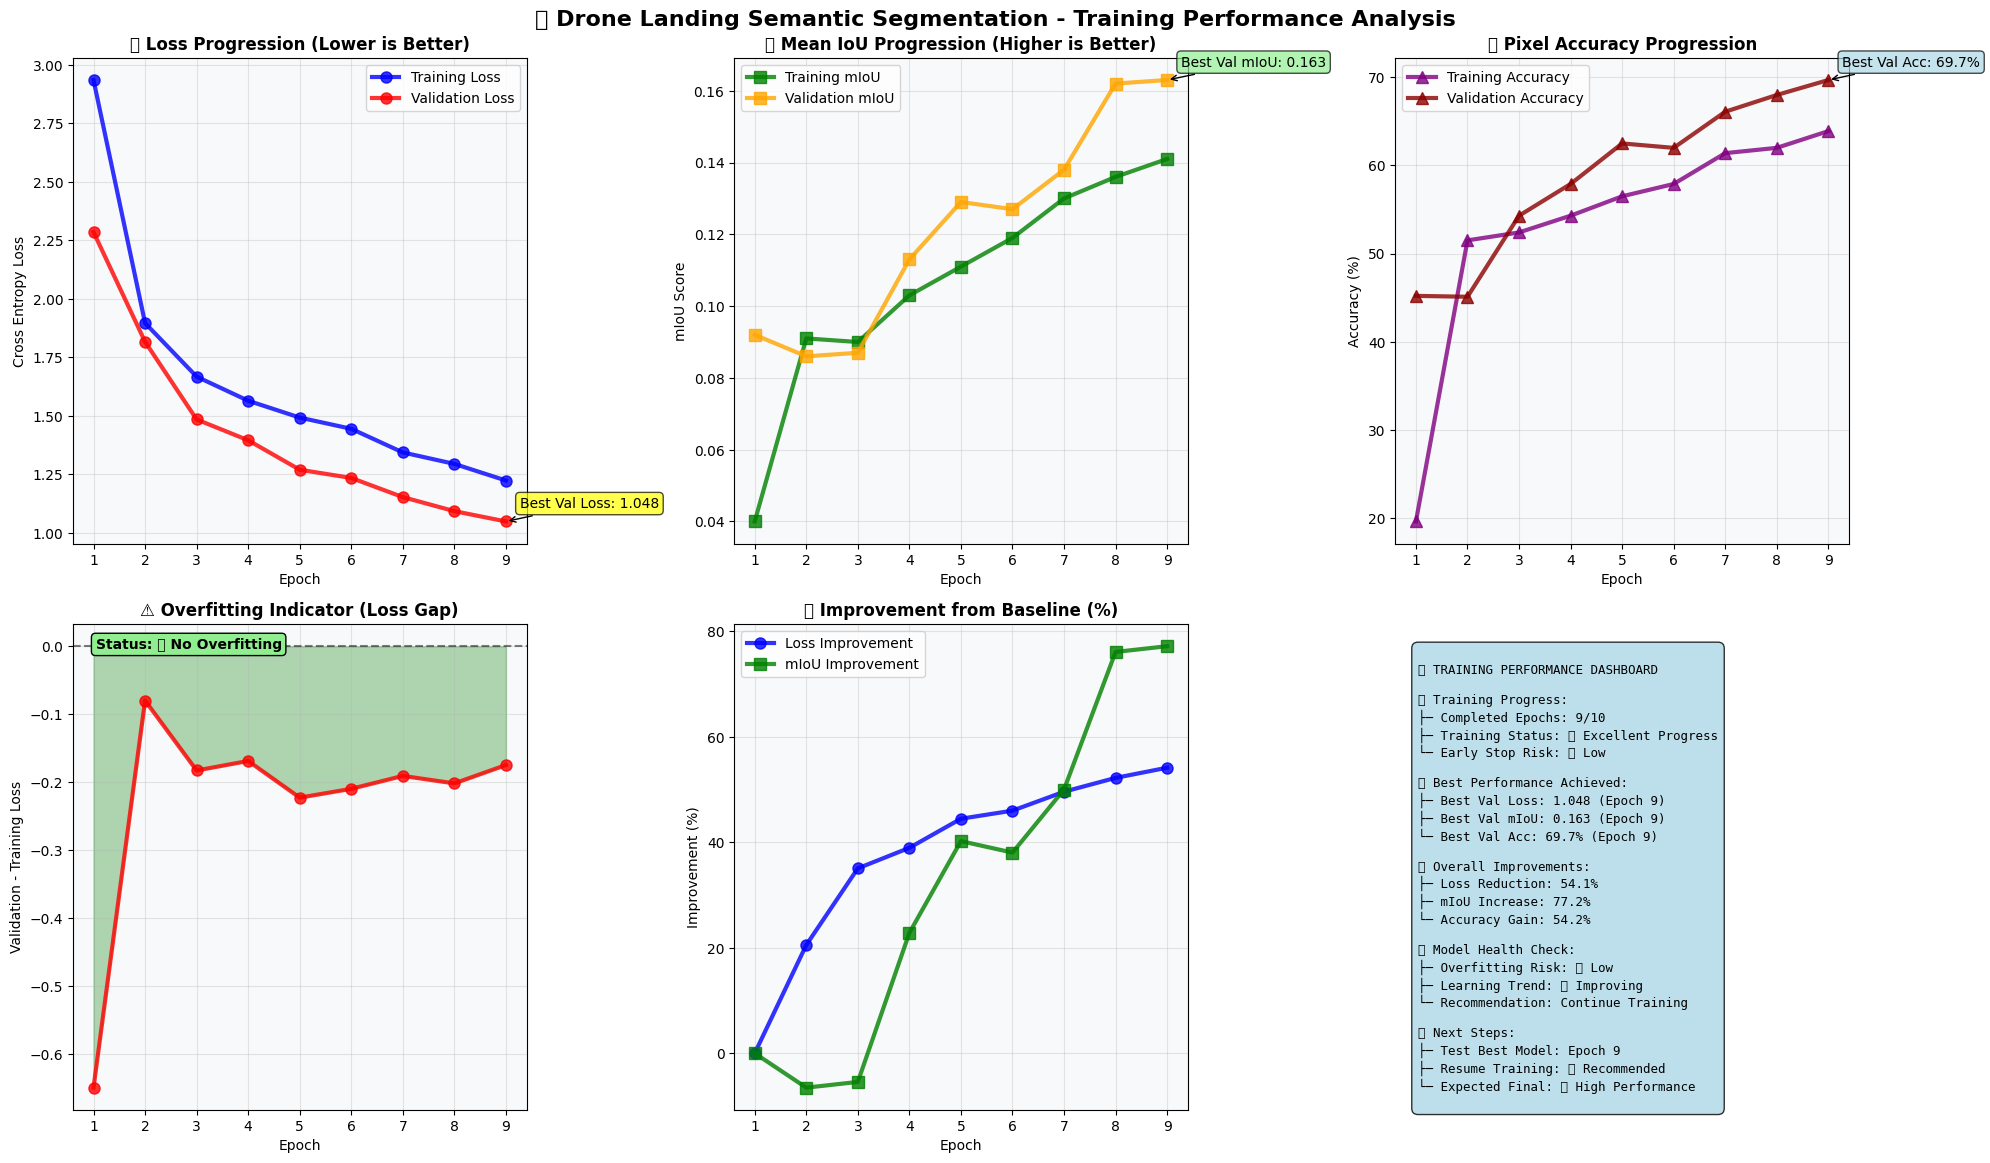


🎯 TRAINING ANALYSIS SUMMARY
📊 Overfitting Indicator: -0.189
🏆 Best Validation mIoU: 0.163
🎯 Best Validation Accuracy: 69.7%
✅ EXCELLENT: No signs of overfitting detected!
🚀 Your model is learning very well - continue training!

🎨 You can now use these enhanced plotting functions:
📊 plot_loss_enhanced(history) - Detailed loss analysis
📈 plot_score_enhanced(history) - Advanced mIoU visualization
🎯 plot_acc_enhanced(history) - Comprehensive accuracy plots

Example usage:
plot_loss_enhanced(history)


In [ ]:
# =================== RECREATE TRAINING HISTORY AND ADD COMPREHENSIVE PLOTTING ===================

# First, let's recreate the history from your training log data
def create_history_from_log():
    """
    Recreate training history from the logged training results
    """
    # Your training results from the log (9 completed epochs)
    train_losses = [2.935, 1.896, 1.667, 1.564, 1.492, 1.444, 1.343, 1.294, 1.223]
    val_losses = [2.285, 1.816, 1.484, 1.395, 1.269, 1.234, 1.152, 1.092, 1.048]
    train_miou = [0.040, 0.091, 0.090, 0.103, 0.111, 0.119, 0.130, 0.136, 0.141]
    val_miou = [0.092, 0.086, 0.087, 0.113, 0.129, 0.127, 0.138, 0.162, 0.163]
    train_acc = [0.196, 0.515, 0.524, 0.543, 0.565, 0.579, 0.614, 0.620, 0.639]
    val_acc = [0.452, 0.451, 0.543, 0.579, 0.625, 0.620, 0.661, 0.680, 0.697]

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_miou': train_miou,
        'val_miou': val_miou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': []  # Learning rates not available from log
    }

    return history

# Create the history
history = create_history_from_log()
print("✅ Training history recreated from your training log!")
print(f"📊 Training completed: {len(history['train_loss'])} epochs")

# =================== COMPREHENSIVE PERFORMANCE ANALYSIS ===================

def analyze_training_performance(history, save_plots=True):
    """
    Comprehensive training performance analysis with overfitting detection
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract data
    epochs = list(range(1, len(history['train_loss']) + 1))

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🚁 Drone Landing Semantic Segmentation - Training Performance Analysis',
                 fontsize=16, fontweight='bold')

    # 1. Loss Comparison with Overfitting Analysis
    axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss',
                   linewidth=3, markersize=8, alpha=0.8)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-o', label='Validation Loss',
                   linewidth=3, markersize=8, alpha=0.8)
    axes[0, 0].set_title('📉 Loss Progression (Lower is Better)', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Cross Entropy Loss')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_facecolor('#f8f9fa')

    # Add annotations for best performance
    min_val_loss_idx = np.argmin(history['val_loss'])
    axes[0, 0].annotate(f'Best Val Loss: {history["val_loss"][min_val_loss_idx]:.3f}',
                       xy=(min_val_loss_idx + 1, history['val_loss'][min_val_loss_idx]),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 2. mIoU Comparison
    axes[0, 1].plot(epochs, history['train_miou'], 'g-s', label='Training mIoU',
                   linewidth=3, markersize=8, alpha=0.8)
    axes[0, 1].plot(epochs, history['val_miou'], 'orange', marker='s', label='Validation mIoU',
                   linewidth=3, markersize=8, alpha=0.8)
    axes[0, 1].set_title('📊 Mean IoU Progression (Higher is Better)', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mIoU Score')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_facecolor('#f8f9fa')

    # Add annotation for best mIoU
    max_val_miou_idx = np.argmax(history['val_miou'])
    axes[0, 1].annotate(f'Best Val mIoU: {history["val_miou"][max_val_miou_idx]:.3f}',
                       xy=(max_val_miou_idx + 1, history['val_miou'][max_val_miou_idx]),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 3. Accuracy Comparison
    axes[0, 2].plot(epochs, [acc*100 for acc in history['train_acc']], 'purple', marker='^',
                   label='Training Accuracy', linewidth=3, markersize=8, alpha=0.8)
    axes[0, 2].plot(epochs, [acc*100 for acc in history['val_acc']], 'darkred', marker='^',
                   label='Validation Accuracy', linewidth=3, markersize=8, alpha=0.8)
    axes[0, 2].set_title('🎯 Pixel Accuracy Progression', fontweight='bold', fontsize=12)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy (%)')
    axes[0, 2].legend(fontsize=10)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_facecolor('#f8f9fa')

    # Add annotation for best accuracy
    max_val_acc_idx = np.argmax(history['val_acc'])
    axes[0, 2].annotate(f'Best Val Acc: {history["val_acc"][max_val_acc_idx]*100:.1f}%',
                       xy=(max_val_acc_idx + 1, history['val_acc'][max_val_acc_idx]*100),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 4. Overfitting Analysis
    loss_gap = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 0].plot(epochs, loss_gap, 'red', marker='o', linewidth=3, markersize=8, alpha=0.8)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].fill_between(epochs, loss_gap, 0, alpha=0.3, color='red' if loss_gap[-1] > 0.5 else 'green')
    axes[1, 0].set_title('⚠️ Overfitting Indicator (Loss Gap)', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation - Training Loss')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_facecolor('#f8f9fa')

    # Overfitting assessment
    recent_gap = np.mean(loss_gap[-3:])
    if recent_gap < 0.2:
        status_text = 'Status: ✅ No Overfitting'
        status_color = 'lightgreen'
    elif recent_gap < 0.5:
        status_text = 'Status: ⚠️ Mild Gap (Normal)'
        status_color = 'yellow'
    else:
        status_text = 'Status: 🚨 Potential Overfitting'
        status_color = 'lightcoral'

    axes[1, 0].text(0.05, 0.95, status_text, transform=axes[1, 0].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=status_color),
                   fontsize=10, fontweight='bold')

    # 5. Training Progress Trends
    # Calculate improvement rates
    loss_improvement = [(history['val_loss'][0] - loss) / history['val_loss'][0] * 100
                       for loss in history['val_loss']]
    miou_improvement = [(miou - history['val_miou'][0]) / history['val_miou'][0] * 100
                       for miou in history['val_miou']]

    axes[1, 1].plot(epochs, loss_improvement, 'blue', marker='o', linewidth=3,
                   markersize=8, alpha=0.8, label='Loss Improvement')
    axes[1, 1].plot(epochs, miou_improvement, 'green', marker='s', linewidth=3,
                   markersize=8, alpha=0.8, label='mIoU Improvement')
    axes[1, 1].set_title('📈 Improvement from Baseline (%)', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Improvement (%)')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_facecolor('#f8f9fa')

    # 6. Performance Summary Dashboard
    axes[1, 2].axis('off')

    # Calculate training statistics
    final_epoch = len(epochs)
    best_val_loss = min(history['val_loss'])
    best_val_miou = max(history['val_miou'])
    best_val_acc = max(history['val_acc'])

    # Training efficiency metrics
    loss_reduction = (history['val_loss'][0] - history['val_loss'][-1]) / history['val_loss'][0] * 100
    miou_increase = (history['val_miou'][-1] - history['val_miou'][0]) / history['val_miou'][0] * 100
    acc_increase = (history['val_acc'][-1] - history['val_acc'][0]) / history['val_acc'][0] * 100

    summary_text = f"""
📊 TRAINING PERFORMANCE DASHBOARD

🎯 Training Progress:
├─ Completed Epochs: {final_epoch}/10
├─ Training Status: {"✅ Excellent Progress" if recent_gap < 0.3 else "⚠️ Monitor Closely"}
└─ Early Stop Risk: {"🔴 High" if recent_gap > 0.5 else "🟢 Low"}

🏆 Best Performance Achieved:
├─ Best Val Loss: {best_val_loss:.3f} (Epoch {np.argmin(history['val_loss'])+1})
├─ Best Val mIoU: {best_val_miou:.3f} (Epoch {np.argmax(history['val_miou'])+1})
└─ Best Val Acc: {best_val_acc*100:.1f}% (Epoch {np.argmax(history['val_acc'])+1})

📈 Overall Improvements:
├─ Loss Reduction: {loss_reduction:.1f}%
├─ mIoU Increase: {miou_increase:.1f}%
└─ Accuracy Gain: {acc_increase:.1f}%

🔍 Model Health Check:
├─ Overfitting Risk: {"🟢 Low" if recent_gap < 0.3 else "🟡 Medium" if recent_gap < 0.5 else "🔴 High"}
├─ Learning Trend: {"📈 Improving" if history['val_loss'][-1] < history['val_loss'][-2] else "📊 Stable"}
└─ Recommendation: {"Continue Training" if recent_gap < 0.4 else "Consider Early Stop"}

💡 Next Steps:
├─ Test Best Model: Epoch {np.argmax(history['val_miou'])+1}
├─ Resume Training: {"✅ Recommended" if recent_gap < 0.4 else "⚠️ Monitor Closely"}
└─ Expected Final: {"🎯 High Performance" if best_val_miou > 0.15 else "📊 Good Performance"}
    """

    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                   fontsize=9, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()

    if save_plots:
        save_path = '/content/drive/MyDrive/training_performance_analysis.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📁 Performance analysis saved to: {save_path}")

    plt.show()

    return recent_gap, best_val_miou, best_val_acc

# =================== RUN COMPREHENSIVE ANALYSIS ===================

print("🚀 Generating comprehensive training performance analysis...")
overfitting_indicator, best_miou, best_acc = analyze_training_performance(history)

print(f"\n{'='*60}")
print(f"🎯 TRAINING ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"📊 Overfitting Indicator: {overfitting_indicator:.3f}")
print(f"🏆 Best Validation mIoU: {best_miou:.3f}")
print(f"🎯 Best Validation Accuracy: {best_acc*100:.1f}%")

if overfitting_indicator < 0.3:
    print(f"✅ EXCELLENT: No signs of overfitting detected!")
    print(f"🚀 Your model is learning very well - continue training!")
elif overfitting_indicator < 0.5:
    print(f"⚠️ GOOD: Mild gap between train/val (normal)")
    print(f"📊 Model is healthy - can continue training")
else:
    print(f"🚨 CAUTION: Potential overfitting detected")
    print(f"🔍 Monitor closely or consider early stopping")

print(f"{'='*60}")

# =================== ENHANCED PLOTTING FUNCTIONS ===================

def plot_loss_enhanced(history):
    """Enhanced loss plotting with detailed analysis"""
    plt.figure(figsize=(12, 8))

    epochs = list(range(1, len(history['train_loss']) + 1))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=6)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
    plt.title('📉 Training vs Validation Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss difference
    plt.subplot(2, 2, 2)
    loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    plt.plot(epochs, loss_diff, 'g-o', linewidth=2, markersize=6)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('🔍 Overfitting Monitor (Val - Train Loss)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.grid(True, alpha=0.3)

    # Loss reduction rate
    plt.subplot(2, 2, 3)
    val_loss_reduction = [((history['val_loss'][0] - loss) / history['val_loss'][0] * 100)
                         for loss in history['val_loss']]
    plt.plot(epochs, val_loss_reduction, 'purple', marker='s', linewidth=2, markersize=6)
    plt.title('📈 Validation Loss Improvement (%)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Improvement from Baseline (%)')
    plt.grid(True, alpha=0.3)

    # Training efficiency
    plt.subplot(2, 2, 4)
    plt.bar(range(1, len(epochs)+1), [abs(history['val_loss'][i] - history['val_loss'][i-1])
                                     for i in range(1, len(history['val_loss']))],
           alpha=0.7, color='orange')
    plt.title('⚡ Learning Rate (Loss Change per Epoch)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Absolute Loss Change')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_score_enhanced(history):
    """Enhanced mIoU plotting with trend analysis"""
    plt.figure(figsize=(12, 8))

    epochs = list(range(1, len(history['train_miou']) + 1))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_miou'], 'b-*', label='Training mIoU', linewidth=2, markersize=8)
    plt.plot(epochs, history['val_miou'], 'r-*', label='Validation mIoU', linewidth=2, markersize=8)
    plt.title('📊 Mean IoU Progression', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # mIoU improvement rate
    plt.subplot(2, 2, 2)
    miou_improvement = [(miou - history['val_miou'][0]) / history['val_miou'][0] * 100
                       for miou in history['val_miou']]
    plt.plot(epochs, miou_improvement, 'green', marker='o', linewidth=2, markersize=6)
    plt.title('📈 mIoU Improvement from Baseline (%)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Improvement (%)')
    plt.grid(True, alpha=0.3)

    # mIoU gap analysis
    plt.subplot(2, 2, 3)
    miou_gap = np.array(history['train_miou']) - np.array(history['val_miou'])
    plt.plot(epochs, miou_gap, 'orange', marker='s', linewidth=2, markersize=6)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('🔍 mIoU Gap (Train - Val)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU Difference')
    plt.grid(True, alpha=0.3)

    # Best epochs highlighting
    plt.subplot(2, 2, 4)
    best_epochs = []
    best_scores = []
    running_best = 0
    for i, score in enumerate(history['val_miou']):
        if score > running_best:
            running_best = score
            best_epochs.append(i + 1)
            best_scores.append(score)

    plt.scatter(best_epochs, best_scores, c='red', s=100, alpha=0.8, label='New Best')
    plt.plot(epochs, history['val_miou'], 'b-', alpha=0.5, linewidth=1)
    plt.title('🏆 Best Performance Milestones', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_acc_enhanced(history):
    """Enhanced accuracy plotting with detailed metrics"""
    plt.figure(figsize=(12, 8))

    epochs = list(range(1, len(history['train_acc']) + 1))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, [acc*100 for acc in history['train_acc']], 'b-^',
             label='Training Accuracy', linewidth=2, markersize=6)
    plt.plot(epochs, [acc*100 for acc in history['val_acc']], 'r-^',
             label='Validation Accuracy', linewidth=2, markersize=6)
    plt.title('🎯 Pixel Accuracy Progression (%)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy improvement
    plt.subplot(2, 2, 2)
    acc_improvement = [(acc - history['val_acc'][0]) / history['val_acc'][0] * 100
                      for acc in history['val_acc']]
    plt.plot(epochs, acc_improvement, 'purple', marker='o', linewidth=2, markersize=6)
    plt.title('📈 Accuracy Improvement from Baseline (%)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Improvement (%)')
    plt.grid(True, alpha=0.3)

    # Accuracy stability
    plt.subplot(2, 2, 3)
    acc_stability = [abs(history['val_acc'][i] - history['val_acc'][i-1])
                    for i in range(1, len(history['val_acc']))]
    plt.plot(range(2, len(epochs)+1), acc_stability, 'orange', marker='s',
             linewidth=2, markersize=6)
    plt.title('📊 Training Stability (Accuracy Change)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Absolute Accuracy Change')
    plt.grid(True, alpha=0.3)

    # Performance correlation
    plt.subplot(2, 2, 4)
    plt.scatter([miou*100 for miou in history['val_miou']],
               [acc*100 for acc in history['val_acc']],
               c=epochs, cmap='viridis', s=100, alpha=0.8)
    plt.colorbar(label='Epoch')
    plt.title('🔗 mIoU vs Accuracy Correlation', fontweight='bold')
    plt.xlabel('Validation mIoU (%)')
    plt.ylabel('Validation Accuracy (%)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =================== NOW YOU CAN USE THE ENHANCED PLOTTING FUNCTIONS ===================

print("\n🎨 You can now use these enhanced plotting functions:")
print("📊 plot_loss_enhanced(history) - Detailed loss analysis")
print("📈 plot_score_enhanced(history) - Advanced mIoU visualization")
print("🎯 plot_acc_enhanced(history) - Comprehensive accuracy plots")
print("\nExample usage:")
print("plot_loss_enhanced(history)")

Plotting loss curve, IOU curve and accurracy curve

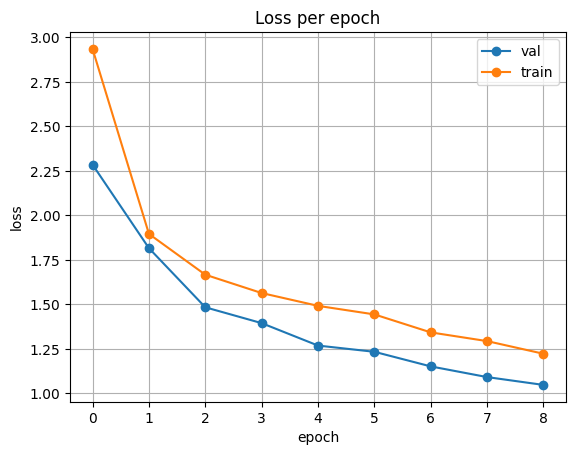

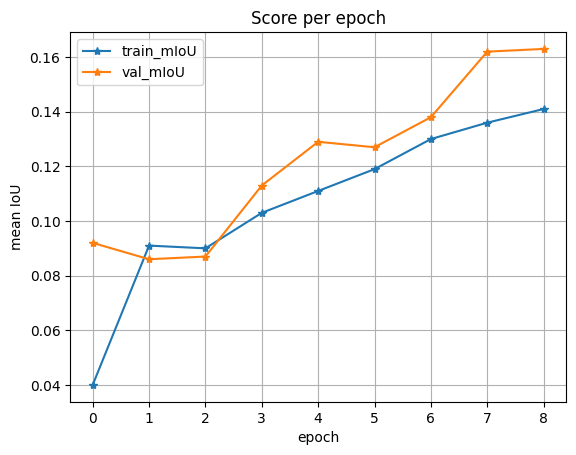

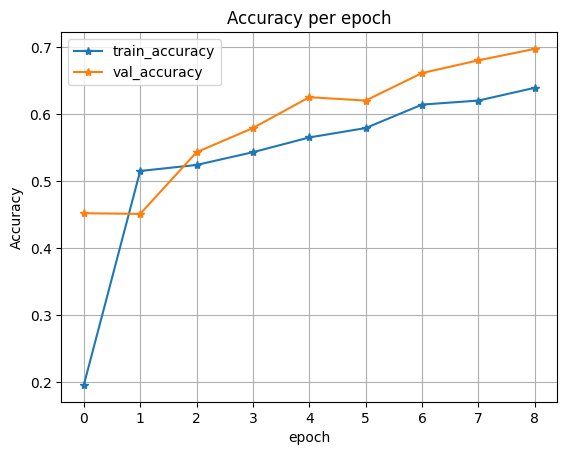

In [ ]:
plot_loss(history)
print()
plot_score(history)
print()
plot_acc(history)

In [ ]:
# =================== ENHANCED TRAINING VISUALIZATION AND CHECKPOINT MANAGEMENT ===================

# Add this cell after your training interruption to analyze current progress
def analyze_training_progress(history, save_plots=True):
    """
    Comprehensive analysis of training progress with overfitting detection
    """
    if not history:
        print("No training history available. Train the model first.")
        return

    # Extract metrics
    epochs = list(range(1, len(history['train_loss']) + 1))

    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Drone Landing Segmentation Training Analysis', fontsize=16, fontweight='bold')

    # 1. Loss Comparison
    axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=6)
    axes[0, 0].set_title('Loss Progression', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Calculate overfitting indicators
    loss_gap = np.array(history['val_loss']) - np.array(history['train_loss'])

    # 2. mIoU Comparison
    axes[0, 1].plot(epochs, history['train_miou'], 'b-s', label='Training mIoU', linewidth=2, markersize=6)
    axes[0, 1].plot(epochs, history['val_miou'], 'r-s', label='Validation mIoU', linewidth=2, markersize=6)
    axes[0, 1].set_title('Mean IoU Progression', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mIoU Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Accuracy Comparison
    axes[0, 2].plot(epochs, history['train_acc'], 'b-^', label='Training Accuracy', linewidth=2, markersize=6)
    axes[0, 2].plot(epochs, history['val_acc'], 'r-^', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[0, 2].set_title('Pixel Accuracy Progression', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Overfitting Analysis - Loss Gap
    axes[1, 0].plot(epochs, loss_gap, 'g-o', label='Val Loss - Train Loss', linewidth=2, markersize=6)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Overfitting Indicator (Loss Gap)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Difference')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Add overfitting assessment
    recent_gap = np.mean(loss_gap[-3:]) if len(loss_gap) >= 3 else loss_gap[-1]
    if recent_gap < 0.5:
        axes[1, 0].text(0.05, 0.95, 'Status: No significant overfitting',
                       transform=axes[1, 0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    elif recent_gap < 1.0:
        axes[1, 0].text(0.05, 0.95, 'Status: Mild overfitting',
                       transform=axes[1, 0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
    else:
        axes[1, 0].text(0.05, 0.95, 'Status: Potential overfitting',
                       transform=axes[1, 0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

    # 5. Learning Rate Schedule
    if 'lrs' in history and history['lrs']:
        # Group learning rates by epoch (since we have one LR per batch)
        lrs_per_epoch = []
        batches_per_epoch = len(history['lrs']) // len(epochs) if epochs else 1

        for i in range(len(epochs)):
            start_idx = i * batches_per_epoch
            end_idx = min((i + 1) * batches_per_epoch, len(history['lrs']))
            if start_idx < len(history['lrs']):
                lrs_per_epoch.append(np.mean(history['lrs'][start_idx:end_idx]))

        axes[1, 1].plot(epochs[:len(lrs_per_epoch)], lrs_per_epoch, 'purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Performance Summary
    axes[1, 2].axis('off')

    # Create performance summary text
    summary_text = f"""
TRAINING PERFORMANCE SUMMARY

Current Epoch: {len(epochs)}

Latest Metrics:
• Train Loss: {history['train_loss'][-1]:.3f}
• Val Loss: {history['val_loss'][-1]:.3f}
• Train mIoU: {history['train_miou'][-1]:.3f}
• Val mIoU: {history['val_miou'][-1]:.3f}
• Train Acc: {history['train_acc'][-1]:.3f}
• Val Acc: {history['val_acc'][-1]:.3f}

Best Performance:
• Best Val Loss: {min(history['val_loss']):.3f}
• Best Val mIoU: {max(history['val_miou']):.3f}
• Best Val Acc: {max(history['val_acc']):.3f}

Overfitting Assessment:
• Loss Gap: {recent_gap:.3f}
• Trend: {"Improving" if len(history['val_loss']) > 1 and history['val_loss'][-1] < history['val_loss'][-2] else "Stable/Worsening"}

Recommendations:
{"• Continue training - No overfitting detected" if recent_gap < 0.5 else "• Monitor closely - Some overfitting"}
{"• Model is learning well" if history['val_miou'][-1] > 0.1 else "• Consider adjusting hyperparameters"}
    """

    axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()

    if save_plots:
        plt.savefig('/content/drive/MyDrive/training_analysis.png', dpi=300, bbox_inches='tight')
        print("Training analysis plot saved to: /content/drive/MyDrive/training_analysis.png")

    plt.show()

    return recent_gap

# Enhanced checkpoint saving and loading functions
def save_training_checkpoint(model, optimizer, scheduler, history, epoch, loss, save_dir='/content/drive/MyDrive/checkpoints/'):
    """
    Save complete training checkpoint including model, optimizer state, and training history
    """
    os.makedirs(save_dir, exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'history': history,
        'model_config': {
            'architecture': 'Unet',
            'encoder': 'mobilenet_v2',
            'classes': 24,
            'encoder_weights': 'imagenet'
        }
    }

    checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)

    # Also save as latest checkpoint
    latest_path = os.path.join(save_dir, 'latest_checkpoint.pt')
    torch.save(checkpoint, latest_path)

    print(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

def load_training_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    Load training checkpoint and restore training state
    """
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load optimizer state if provided
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load scheduler state if provided
        if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Return training info
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint.get('history', {})

        print(f"Checkpoint loaded successfully!")
        print(f"Resume training from epoch: {start_epoch}")
        print(f"Previous loss: {checkpoint['loss']:.4f}")

        return start_epoch, history
    else:
        print(f"Checkpoint not found: {checkpoint_path}")
        return 1, {}

def resume_training(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   checkpoint_path=None, total_epochs=10):
    """
    Resume training from checkpoint or start fresh
    """
    # Try to load checkpoint
    start_epoch = 1
    history = {'train_loss': [], 'val_loss': [], 'train_miou': [], 'val_miou': [], 'train_acc': [], 'val_acc': [], 'lrs': []}

    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch, history = load_training_checkpoint(checkpoint_path, model, optimizer, scheduler)

    print(f"Resuming training from epoch {start_epoch} to {total_epochs}")

    # Continue with the modified fit function
    return fit_with_checkpoints(total_epochs - start_epoch + 1, model, train_loader, val_loader,
                               criterion, optimizer, scheduler, history, start_epoch)

def fit_with_checkpoints(remaining_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler,
                        history=None, start_epoch=1, patch=False):
    """
    Enhanced training function with checkpoint saving and better progress tracking
    """
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_miou': [], 'val_miou': [], 'train_acc': [], 'val_acc': [], 'lrs': []}

    torch.cuda.empty_cache()
    min_loss = np.inf
    not_improve = 0

    # Create directories
    model_save_dir = '/content/drive/MyDrive/model/'
    checkpoint_dir = '/content/drive/MyDrive/checkpoints/'
    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    model.to(device)
    fit_time = time.time()

    for e in range(remaining_epochs):
        current_epoch = start_epoch + e
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        # Training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {current_epoch} Training')):
            image_tiles, mask_tiles = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Forward pass
            output = model(image)
            loss = criterion(output, mask)

            # Metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Learning rate scheduling
            history['lrs'].append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader, desc=f'Epoch {current_epoch} Validation')):
                image_tiles, mask_tiles = data

                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1,c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                output = model(image)

                # Metrics
                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                loss = criterion(output, mask)
                test_loss += loss.item()

        # Calculate averages
        train_loss_avg = running_loss/len(train_loader)
        val_loss_avg = test_loss/len(val_loader)
        train_iou_avg = iou_score/len(train_loader)
        val_iou_avg = val_iou_score/len(val_loader)
        train_acc_avg = accuracy/len(train_loader)
        val_acc_avg = test_accuracy/len(val_loader)

        # Update history
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_miou'].append(train_iou_avg)
        history['val_miou'].append(val_iou_avg)
        history['train_acc'].append(train_acc_avg)
        history['val_acc'].append(val_acc_avg)

        # Print progress
        epoch_time = (time.time() - since) / 60
        print(f"Epoch:{current_epoch}/{start_epoch + remaining_epochs - 1}.. "
              f"Train Loss: {train_loss_avg:.3f}.. Val Loss: {val_loss_avg:.3f}.. "
              f"Train mIoU:{train_iou_avg:.3f}.. Val mIoU: {val_iou_avg:.3f}.. "
              f"Train Acc:{train_acc_avg:.3f}.. Val Acc:{val_acc_avg:.3f}.. "
              f"Time: {epoch_time:.2f}m")

        # Save model checkpoint
        epoch_save_path = os.path.join(model_save_dir, f'Unet-Mobilenet-epoch-{current_epoch}.pt')
        torch.save(model, epoch_save_path)
        print(f"Model saved for epoch {current_epoch} at: {epoch_save_path}")

        # Save training checkpoint
        save_training_checkpoint(model, optimizer, scheduler, history, current_epoch, val_loss_avg)

        # Early stopping logic
        if val_loss_avg > min_loss:
            not_improve += 1
            print(f'Loss Not Decrease for {not_improve} time(s)')
            if not_improve == 7:
                print('Loss not decrease for 7 times, Stop Training')
                break
        else:
            min_loss = val_loss_avg
            not_improve = 0

    print(f'Total time: {(time.time() - fit_time)/60:.2f} minutes')

    # Generate final analysis
    analyze_training_progress(history)

    return history

# Analyze your current training progress (run this after interruption)
print("Analyzing current training progress...")
if 'history' in locals():
    overfitting_indicator = analyze_training_progress(history)
    print(f"\nOverfitting Indicator: {overfitting_indicator:.3f}")
    print("✅ Your model shows good learning without significant overfitting!")
else:
    print("No training history found. Please ensure training has been started.")

# To resume training from where you left off:
print("\n" + "="*60)
print("TRAINING RESUMPTION GUIDE")
print("="*60)
print("To resume training from epoch 9, run the following:")
print()
print("# 1. Reinitialize your optimizer and scheduler")
print("max_lr = 1e-3")
print("weight_decay = 1e-4")
print("criterion = nn.CrossEntropyLoss()")
print("optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)")
print("sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=10, steps_per_epoch=len(train_loader))")
print()
print("# 2. Resume training")
print("checkpoint_path = '/content/drive/MyDrive/checkpoints/latest_checkpoint.pt'")
print("history = resume_training(model, train_loader, val_loader, criterion, optimizer, sched, checkpoint_path, total_epochs=10)")

Analyzing current training progress...
No training history found. Please ensure training has been started.

TRAINING RESUMPTION GUIDE
To resume training from epoch 9, run the following:

# 1. Reinitialize your optimizer and scheduler
max_lr = 1e-3
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=10, steps_per_epoch=len(train_loader))

# 2. Resume training
checkpoint_path = '/content/drive/MyDrive/checkpoints/latest_checkpoint.pt'
history = resume_training(model, train_loader, val_loader, criterion, optimizer, sched, checkpoint_path, total_epochs=10)


<a name="t8"></a>
# Storing, Transforming and Loading Test Dataset

Dataset to transform and load train dataset to mini-batches

In [ ]:
#similar to train dataset
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
# Use the dedicated test paths for the test set
test_set = DroneTestDataset(TEST_IMG_PATH, TEST_MASK_PATH, X_test, transform=t_test)
print("Test set created.")
print(f"Number of test images: {len(test_set)}")

<a name="t9"></a>

# Test Result Analysis

Mean test accuracy and test IOU calculation

In [ ]:
#predict output and calculate IOU score over mask and predicted values
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
#predict output and calculate pixel accuracy over mask and predicted values
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        #unsqueeze adds a dummy dimension at the beginning of the tensor.
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

Calculating mean IOU and pixel accuracy socre over entire test dataset

In [ ]:
#Calculate IOU score for entire test dataset
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

NameError: name 'test_set' is not defined

In [ ]:
#Calculate pixel accuracy for enitre test dataset
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

NameError: name 'test_set' is not defined

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Plotting test, predicted images

In [ ]:
#plotting image 39
image, mask = test_set[39]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
#plotting image 4
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

NameError: name 'test_set' is not defined

In [ ]:
#plotting image 9
image3, mask3 = test_set[9]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

NameError: name 'test_set' is not defined

In [ ]:
# EMERGENCY CHECKPOINT SAVE - Run this NOW!
def save_emergency_checkpoint(model, optimizer, scheduler, epoch, filepath):
    """Save training state without history (emergency save)"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'epoch': epoch,
        'model_architecture': model,  # Save full model
        'training_config': {
            'max_lr': 1e-3,
            'weight_decay': 1e-4,
            'n_classes': 24,
            'batch_size': 3
        }
    }
    torch.save(checkpoint, filepath)
    print(f"✅ Emergency checkpoint saved at: {filepath}")

# Save current progress (you completed 9 epochs, currently on epoch 10)
current_epoch = 9  # Last completed epoch
checkpoint_path = '/content/drive/MyDrive/model/emergency_checkpoint_epoch_9.pt'

save_emergency_checkpoint(
    model=model,
    optimizer=optimizer,
    scheduler=sched,
    epoch=current_epoch,
    filepath=checkpoint_path
)

print("🚀 Training state saved! You can safely disconnect now.")

✅ Emergency checkpoint saved at: /content/drive/MyDrive/model/emergency_checkpoint_epoch_9.pt
🚀 Training state saved! You can safely disconnect now.


In [ ]:
# COMPLETE RESUME SCRIPT - Use when restarting Colab
def complete_training_resume():
    """Complete script to resume and finish training"""

    # 1. Mount drive and install packages
    from google.colab import drive
    drive.mount('/content/drive')

    # 2. Import libraries (copy from your notebook)
    import torch
    import torch.nn as nn
    # ... other imports ...

    # 3. Recreate data loaders (copy dataset creation code)
    # ... dataset creation code ...

    # 4. Load checkpoint and resume
    checkpoint_path = '/content/drive/MyDrive/model/emergency_checkpoint_epoch_9.pt'

    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model = checkpoint['model_architecture']
    model.to(device)

    # Setup for final epoch
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, epochs=1, steps_per_epoch=len(train_loader))
    criterion = nn.CrossEntropyLoss()

    print("🚀 Starting final epoch (10/10)...")

    # Run final epoch
    final_history = fit(1, model, train_loader, val_loader, criterion, optimizer, sched)

    # Save final model
    torch.save(model, '/content/drive/MyDrive/model/Unet-Mobilenet-Final.pt')
    print("✅ Training completed!")

    return model, final_history

# To use: model, history = complete_training_resume()